In [1]:
%load_ext autoreload
%autoreload 2
import os
import random

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
import keras
from keras import layers, optimizers, losses, metrics, callbacks, ops
from PIL import Image

# from swin_transformer import SwinTransformer

2024-01-12 08:59:55.090233: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/env_dl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
gpus = tf.config.experimental.list_physical_devices(device_type="GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
plt.style.use("seaborn-v0_8")

2024-01-12 08:59:57.155253: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-12 08:59:57.181400: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-12 08:59:57.181656: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Dataset

In [3]:
DATASET_PATH = "/mnt/dl/datasets/Oxford102FlowersSplits/"
LABELS = {i: k.strip() for i, k in enumerate(open(os.path.join(DATASET_PATH, "names.txt")))}
batch_size = 64
img_size = 224
SIZE = 128
batch_size = 32
num_classes = len(LABELS)
patch_size = 16
num_patches = img_size ** 2 / patch_size **2

In [4]:
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

In [5]:
def load_dataset(split):
    
    def load_img(img_fname):
        img_bytes = tf.io.read_file(img_fname)
        img = tf.io.decode_jpeg(img_bytes)
        img = tf.image.resize(img, (img_size, img_size))
        img = tf.cast(img, tf.float32)
        return img
        
    path = os.path.join(DATASET_PATH, split, )
    img_files = os.listdir(os.path.join(path, "jpeg"))
    img_files = sorted(img_files, key=lambda x: int(x.replace(".jpeg", "")))
    img_files = list(img_files)[:SIZE]
    
    labels = list(open(os.path.join(path, "label", "label.txt"),))
    labels = [int(l.strip()) for l in labels][:SIZE]
    
    img_files = [os.path.join(path, "jpeg", name) for name in img_files]
    
    img_ds = tf.data.Dataset.from_tensor_slices(img_files).map(load_img).cache()
    label_ds = tf.data.Dataset.from_tensor_slices(labels).cache()
    ds = tf.data.Dataset.zip((img_ds, label_ds))
    return ds

In [6]:
train_ds = load_dataset("train")
validation_ds = load_dataset("validation")
test_ds = load_dataset("test")

2024-01-12 08:59:57.366774: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-12 08:59:57.367122: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-12 08:59:57.367428: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [7]:
aug_layers = [layers.RandomRotation(0.1), layers.RandomFlip()]

def preprocess(img, label, training):
    if training:
        for aug in aug_layers:
            img = aug(img)
    return tf.cast(img, tf.float32), label
    
train_ds = train_ds.shuffle(buffer_size=2048, seed=0).map(lambda img, label: preprocess(img, label, training=True)).batch(batch_size)
validation_ds = validation_ds.map(lambda img, label: preprocess(img, label, training=False), num_parallel_calls=5).batch(batch_size)
test_ds = test_ds.map(lambda img, label: preprocess(img, label, training=False), num_parallel_calls=5).batch(batch_size)

## Swin transformer

In [8]:
x, _ = next(iter(train_ds))
x = x[0]

2024-01-12 08:59:58.311765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_17' with dtype resource
	 [[{{node Placeholder/_17}}]]
2024-01-12 08:59:58.312093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_17' with dtype resource
	 [[{{node Placeholder/_17}}]]
2024-01-12 08:59:58.694186: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): CANCELLED: RecvAsync is cancelled.
	 [[{{node random_flip_1/ReadVariableOp_3/_16}}]] [type.googleapis.com/te

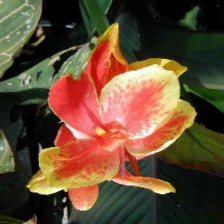

In [9]:
img = Image.fromarray(x.numpy().astype(np.uint8))
img

In [10]:
img.size

(224, 224)

In [11]:
class PartitionLayer(keras.Layer):
    
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
    
    def call(self, x):
        b, h, w, c = ops.shape(x)
        n_patch = h // self.patch_size
        _x = ops.split(x, n_patch, axis=1)
        _x = ops.stack(_x, 1)
        _x = ops.split(_x, n_patch, 3)
        _x = ops.stack(_x, 3)
        _x = ops.transpose(_x, (0, 1, 3, 2, 4, 5))
        return _x

In [12]:
part_x = PartitionLayer(49)(tf.expand_dims(x, 0))[0]

In [13]:
part_x.shape

TensorShape([4, 4, 56, 56, 3])

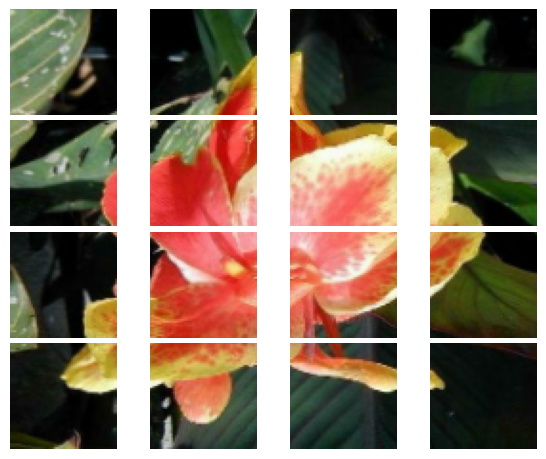

In [14]:
fig = plt.figure()
row, col = part_x.shape[:2]
for i in range(row):
    for j in range(col):
        ax = fig.add_subplot(row, col, i*col + j + 1)
        ax.imshow(part_x[i, j].numpy().astype(np.uint8))
        ax.grid(False)
        ax.set_axis_off()
fig.tight_layout()
fig.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1, wspace=0.001, hspace=0.05)

In [15]:
class PartitionMerging(keras.Layer):
    
    def __init__(self, merge=2,**kwargs):
        super().__init__(**kwargs)
        self.merge = merge
    def call(self, x):
        b, npatch, *_= x.shape
        _x = ops.split(x, npatch, 2)
        patches = []
        for i in range(npatch // self.merge):
            merge_tensor = _x[i*self.merge:(i+1)*self.merge]
            patches.append(ops.concatenate(merge_tensor, -2))
        _x = ops.concatenate(patches, 2)
        _x = ops.split(_x, npatch, 1)
        patches = []
        for i in range(npatch // self.merge):
            merge_tensor = _x[i*self.merge:(i+1)*self.merge]
            patches.append(ops.concatenate(merge_tensor, -3))
        _x = ops.concatenate(patches, 1)
        return _x

In [16]:
merge_x = PartitionMerging(4)(tf.expand_dims(part_x, 0))[0]
merge_x.shape

TensorShape([1, 1, 224, 224, 3])

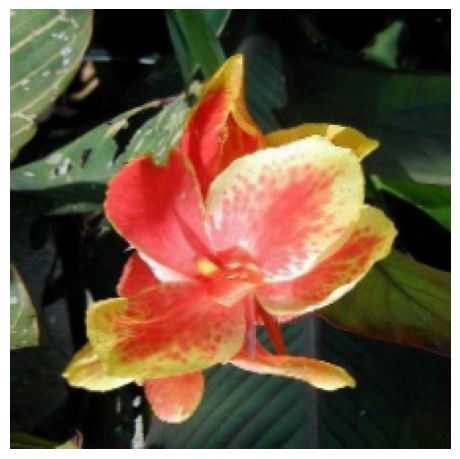

In [17]:
fig = plt.figure()
row, col = merge_x.shape[:2]
for i in range(row):
    for j in range(col):
        ax = fig.add_subplot(row, col, i*col + j + 1)
        ax.imshow(merge_x[i, j].numpy().astype(np.uint8))
        ax.grid(False)
        ax.set_axis_off()
fig.tight_layout()
fig.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1, wspace=0.001, hspace=0.05)

In [22]:
class Classifier(keras.Layer):
    def __init__(self, h1, h2, **kwargs):
        super().__init__(**kwargs)
        self.net = keras.Sequential(
            [
                layers.Dense(h1),
                layers.Dropout(0.1), 
                layers.Dense(h2)
            ]
        )

    def call(self, x):
        return self.net(x)
    

In [19]:
class MLP(keras.Layer):
    def __init__(self,  **kwargs):
        super().__init__(**kwargs)
    
    def build(self, input_shape):
        C = input_shape[-1]
        self.net = keras.Sequential(
            [
                layers.Dense(C * 4),
                layers.Activation("gelu"),
                layers.Dropout(0.1),
                layers.Dense(C),
            ]
        )
        return super().build(input_shape)

    def call(self, x):
        return self.net(x)

class MSA(keras.Layer):
    def __init__(self, heads=8, **kwargs):
        super().__init__(**kwargs)
        self.heads = heads
        self.head_dim = None
        
    def build(self, input_shape):
        C = input_shape[-1]
        self.linear = layers.Dense(C)
        
        self.head_dim = C // self.heads
        self.qhead = layers.Dense(C, use_bias=False)
        self.khead = layers.Dense(C, use_bias=False)
        self.vhead = layers.Dense(C, use_bias=False)
        return super().build(input_shape)

    def call(self, x, mask=None):
        x = ops.transpose(x, (1, 0, 2, 3))
        mask = ops.transpose(mask, (1, 0, 2, 3))
        x = ops.vectorized_map(self.vectorized_msa_window, (x, mask))
        x = ops.transpose(x, (1, 0, 2, 3))
        return x
    
    def vectorized_msa_window(self, arg):
        x, mask = arg
        # B, S, C
        bz, sz, C = ops.shape(x)
        C = x.shape[-1]
        q, k, v = x, x, x #self.qf(x), self.kf(x), self.vf(x)
        
        qh = self.qhead(q)
        kh = self.khead(k)
        
        qh = ops.reshape(qh, (bz, sz, self.heads, self.head_dim))
        qh = ops.transpose(qh, (0, 2, 1, 3))
        kh = ops.reshape(kh, (bz, sz, self.heads, self.head_dim))
        kh = ops.transpose(kh, (0, 2, 1, 3))
        
        inn_prod = ops.matmul(qh, ops.transpose(kh, (0, 1, 3, 2)))
        # TODO add bias
        scaled_inn_prod = inn_prod / ops.sqrt(self.head_dim)
        
        attn_weights = ops.softmax(scaled_inn_prod, -1)
        mask = ops.broadcast_to(mask, ops.shape(attn_weights)) 
        masked_attn_weights = ops.multiply(attn_weights, mask)
        
        vh = self.vhead(v)
        vh = ops.reshape(vh, (bz, sz, self.heads, self.head_dim))
        vh = ops.transpose(vh, (0, 2, 1, 3))  
        
        x = ops.matmul(masked_attn_weights, vh)
        x = ops.transpose(x, (0, 2, 1, 3))
        x = ops.reshape(x, (bz, sz, C))
        x = self.linear(x)
        x = tf.nn.dropout(x, 0.1)
        return x

class SWMSA(MSA):
    def __init__(self, window_size, **kwargs):
        super().__init__(**kwargs)
        self.window_size = window_size
        
    def build(self, input_shape):
        bz, h, w, C = input_shape
        w_ceil, w_floor = np.floor(self.window_size / 2).astype(int), np.ceil(self.window_size / 2).astype(int)

        self.shift_length = min(w_ceil, w_floor)
        mask = np.zeros((h, w)).astype(int)
        top = [(0, self.shift_length), 
                (self.shift_length, h - self.shift_length),
                (h - self.shift_length, h)
                ]
        side = [(0, self.shift_length), 
                (self.shift_length, w - self.shift_length),
                (w - self.shift_length, w)
                ]
        g = 1
        for i in range(len(top)):
            for j in range(len(side)):
                mask[top[i][0]: top[i][1], side[j][0]: side[j][1]] = g
                g += 1    
        self.mask = np.roll(mask, (-self.shift_length, -self.shift_length), (0, 1))
        self.mask = np.reshape(self.mask, (1, h, w, 1))
        
        self.partition_layer = PartitionLayer(self.window_size)
        self.merge_layer = PartitionMerging(h // self.window_size)
        self.reshape = layers.Reshape(( 
                                       (h // self.window_size) * (w // self.window_size),
                                    self.window_size * self.window_size, 
                                    C))
        super().build(input_shape)

    def call(self, x, mask=None):
        bz, h, w, C = ops.shape(x)
        x = ops.roll(x, -self.shift_length, 1)
        x = ops.roll(x, -self.shift_length, 2)
        
        x = self.partition_layer(x)
        mask = ops.convert_to_tensor(self.mask)
        
        mask = self.partition_layer(mask)

        x = self.reshape(x)
        mask_shape = ops.shape(mask)
        mask1 = ops.reshape(mask, (mask_shape[0], x.shape[1], x.shape[2], 1))
        mask2 = ops.reshape(mask, (mask_shape[0], x.shape[1], 1, x.shape[2]))
        mask = ops.equal(mask1, mask2)
        mask = ops.cast(mask, tf.float32)
        
        mask = ops.where(mask, mask, -65555.)
        
        x = super().call(x, mask)
        x = ops.reshape(x, (bz, x.shape[1], self.window_size, self.window_size, C))
        x = ops.reshape(x, (bz, int(np.sqrt(x.shape[1])), int(np.sqrt(x.shape[1])), 
                            self.window_size, self.window_size, C
                            ))
        
        x = self.merge_layer(x)
        x = ops.squeeze(x, (1, 2))
        return x

class WMSA(MSA):
    def __init__(self, window_size, **kwargs):
        super().__init__(**kwargs)
        self.window_size = window_size
        
    def build(self, input_shape):
        bz, h, w, C = input_shape
        self.partition_layer = PartitionLayer(self.window_size)
        self.merge_layer = PartitionMerging(h // self.window_size)
        self.reshape = layers.Reshape(( 
                                       (h // self.window_size) * (w // self.window_size),
                                    self.window_size * self.window_size, 
                                    C))
        super().build(input_shape)

    def call(self, x, mask=None):
        bz, h, w, C = ops.shape(x)
        x = self.partition_layer(x)

        x = self.reshape(x)
        seq_length = self.window_size ** 2

        mask = ops.ones((1, 1, seq_length, seq_length))
        x = super().call(x, mask)
        x = ops.reshape(x, (bz, x.shape[1], self.window_size, self.window_size, C))
        x = ops.reshape(x, (bz, int(np.sqrt(x.shape[1])), int(np.sqrt(x.shape[1])), 
                            self.window_size, self.window_size, C
                            ))
        
        x = self.merge_layer(x)
        x = ops.squeeze(x, (1, 2))
        return x

class SwineEncoderBlock(keras.Layer):
    def __init__(self, window_size, att_tp, **kwargs):
        super().__init__(**kwargs)
        self.att_tp = att_tp
        self.window_size = window_size

    def build(self, input_shape):
        self.ln1 = layers.LayerNormalization()
        self.ln2 = layers.LayerNormalization()
        
        self.att_fn = WMSA(self.window_size) if self.att_tp == "window" else SWMSA(self.window_size)
        
        self.residual1 = layers.Add()
        self.residual2 = layers.Add()
        
        self.mlp = MLP()
        super().build(input_shape)

    def compute_output_shape(self, input_shape):
        return input_shape

    def call(self, x):
        prev_x = x
        x = self.ln1(x)
        x = self.att_fn(x)
        x = self.residual1([x, prev_x])
        
        prev_x = x
        x = self.ln2(x)
        x = self.mlp(x)
        x = self.residual2([x, prev_x])
        
        return x
    
class SwineEncoder(keras.Layer):
    def __init__(self, window_size=7, **kwargs):
        super().__init__(**kwargs)
        self.window_size = window_size

    def build(self, input_shape):
        self.window_eb = SwineEncoderBlock(window_size=7, att_tp="window")
        self.shifted_window_eb = SwineEncoderBlock(window_size=7, att_tp="shifted_window")
        return super().build(input_shape)

    def call(self, x):
        x = self.window_eb(x)
        x = self.shifted_window_eb(x)
        
        return x
    
class SwinBlock(keras.Layer):
    def __init__(self, patch_size, window_size=7, nblocks=2, 
                 merge=True, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.window_size = window_size
        self.merge = merge
        self.nblocks = nblocks

    def build(self, input_shape):
        bz, H, W, C = input_shape
        self.new_C = 2*C
        self.merge_op = (keras.Sequential(
            [PartitionMerging(), 
             layers.Reshape((H // 2, W//2, 4*C)),
             layers.Dense(C * 2), 
             ]) if self.merge 
            else keras.Sequential([layers.Identity(), 
                                   layers.Reshape((H , W, -1))
                                   ])
        )
        self.swin_encoder = keras.Sequential([SwineEncoder() for _ in range(self.nblocks // 2)])
        return super().build(input_shape)
    
    def call(self, x):
        bz, h, w, C = ops.shape(x)
        x = ops.expand_dims(ops.expand_dims(x, 3), 4)
        x = self.merge_op(x)
        x = self.swin_encoder(x)
        
        return x

class SwinTransformer(keras.Layer):
    def __init__(self, C,  name="swin_transformer", **kwargs):
        super().__init__(name=name, **kwargs)
        self.C = C

    def build(self, input_shape):
        _, H, W, c = input_shape
        self.rescaling = layers.Rescaling(
            1/255., name=f"{self.name}_rescaling")
        
        # Patch partition B, num_p, num_p, pz, pz, 2
        self.patch_partition = PartitionLayer(4)
        # Linear Embedding
        self.reshape = layers.Reshape((H // 4 , W // 4, -1))
        self.proj1 = layers.Dense(self.C)

        self.swin_block1 = SwinBlock(patch_size=4, window_size=7, merge=False)
        self.swin_block2 = SwinBlock(patch_size=8, window_size=7, merge=True)
        self.swin_block3 = SwinBlock(patch_size=16, window_size=7, nblocks=6)
        self.swin_block4 = SwinBlock(patch_size=32, window_size=7,)

        self.reshape_pool = layers.Reshape((H//32 * W//32, -1))
        return super().build(input_shape)

    def call(self, x):
        x = self.rescaling(x)
        x = self.patch_partition(x)
        x = self.reshape(x)
        x = self.proj1(x)
        
        # (None, npatch, npatch, C)  
        x = self.swin_block1(x)
        x = self.swin_block2(x)
        x = self.swin_block3(x)
        x = self.swin_block4(x)

        return x

In [23]:
C = 96
input = keras.Input((img_size, img_size, 3))
swin_layer = SwinTransformer(C)
x = swin_layer(input)
pooling = layers.GlobalAveragePooling2D()(x)
classifier = Classifier(1024, num_classes)(pooling)

swin_model = keras.Model(input, classifier)
swin_model.summary()

Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 224, 224, 3)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ swin_transformer                │ (None, 7, 7, 768)         │ 27,477,024 │
│ (SwinTransformer)               │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling2d_1      │ (None, 768)               │          0 │
│ (GlobalAveragePooling2D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ classifier_1 (Classifier)       │ (None, 102)               │    892,006 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 28,369,030 (108.22 MB)

 Trainable params: 28,369,030 (108.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
swin_model.compile(optimizer=optimizers.Adam(1e-3),
                   loss=losses.SparseCategoricalCrossentropy(),
                   metrics=[metrics.SparseCategoricalAccuracy()])
history = swin_model.fit(train_ds, validation_data=validation_ds,
                         epochs=75)